In [101]:
import pandas as pd
import gspread
from google.auth import default
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV

In [102]:
from google.colab import auth

auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)
worksheet = gc.open('cancer patient data sets').worksheet('Sheet')
data = worksheet.get_all_values()

In [103]:
# data to dataframe
df = pd.DataFrame(data[1:], columns=data[0])
df.head()

,Patient Id,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,Balanced Diet,...,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level
0,P1,33,1,2,4,5,4,3,2,2,...,3,4,2,2,3,1,2,3,4,Low
1,P10,17,1,3,1,5,3,4,2,2,...,1,3,7,8,6,2,1,7,2,Medium
2,P100,35,1,4,5,6,5,5,4,6,...,8,7,9,2,1,4,6,7,2,High
3,P1000,37,1,7,7,7,7,6,7,7,...,4,2,3,1,4,5,6,7,5,High
4,P101,46,1,6,8,7,7,7,6,7,...,3,2,4,1,4,2,4,2,3,High


In [104]:
df['Level'].describe().T

,Level
count,1000
unique,3
top,High
freq,365


In [105]:
level_mapping = {
    'Low': 1,
    'Medium': 2,
    'High': 3
}

# Apply the mapping to the 'Level' column
df['Level'] = df['Level'].map(level_mapping)
df.drop('Patient Id', axis=1, inplace=True)
df.head()

,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,Balanced Diet,Obesity,...,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level
0,33,1,2,4,5,4,3,2,2,4,...,3,4,2,2,3,1,2,3,4,1
1,17,1,3,1,5,3,4,2,2,2,...,1,3,7,8,6,2,1,7,2,2
2,35,1,4,5,6,5,5,4,6,7,...,8,7,9,2,1,4,6,7,2,3
3,37,1,7,7,7,7,6,7,7,7,...,4,2,3,1,4,5,6,7,5,3
4,46,1,6,8,7,7,7,6,7,7,...,3,2,4,1,4,2,4,2,3,3


In [106]:
# Convert relevant columns to numeric, handling errors
for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    except ValueError:
        print(f"Column '{col}' could not be converted to numeric. Check for inconsistent data types.")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Age                       1000 non-null   int64
 1   Gender                    1000 non-null   int64
 2   Air Pollution             1000 non-null   int64
 3   Alcohol use               1000 non-null   int64
 4   Dust Allergy              1000 non-null   int64
 5   OccuPational Hazards      1000 non-null   int64
 6   Genetic Risk              1000 non-null   int64
 7   chronic Lung Disease      1000 non-null   int64
 8   Balanced Diet             1000 non-null   int64
 9   Obesity                   1000 non-null   int64
 10  Smoking                   1000 non-null   int64
 11  Passive Smoker            1000 non-null   int64
 12  Chest Pain                1000 non-null   int64
 13  Coughing of Blood         1000 non-null   int64
 14  Fatigue                   1000 non-null  

In [107]:
dfs = df.drop(columns=['Level'])
dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Age                       1000 non-null   int64
 1   Gender                    1000 non-null   int64
 2   Air Pollution             1000 non-null   int64
 3   Alcohol use               1000 non-null   int64
 4   Dust Allergy              1000 non-null   int64
 5   OccuPational Hazards      1000 non-null   int64
 6   Genetic Risk              1000 non-null   int64
 7   chronic Lung Disease      1000 non-null   int64
 8   Balanced Diet             1000 non-null   int64
 9   Obesity                   1000 non-null   int64
 10  Smoking                   1000 non-null   int64
 11  Passive Smoker            1000 non-null   int64
 12  Chest Pain                1000 non-null   int64
 13  Coughing of Blood         1000 non-null   int64
 14  Fatigue                   1000 non-null  

In [108]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1000.0,37.174,12.005493,14.0,27.75,36.0,45.0,73.0
Gender,1000.0,1.402,0.490547,1.0,1.00,1.0,2.0,2.0
Air Pollution,1000.0,3.840,2.030400,1.0,2.00,3.0,6.0,8.0
Alcohol use,1000.0,4.563,2.620477,1.0,2.00,5.0,7.0,8.0
Dust Allergy,1000.0,5.165,1.980833,1.0,4.00,6.0,7.0,8.0
OccuPational Hazards,1000.0,4.840,2.107805,1.0,3.00,5.0,7.0,8.0
Genetic Risk,1000.0,4.580,2.126999,1.0,2.00,5.0,7.0,7.0
chronic Lung Disease,1000.0,4.380,1.848518,1.0,3.00,4.0,6.0,7.0
Balanced Diet,1000.0,4.491,2.135528,1.0,2.00,4.0,7.0,7.0
Obesity,1000.0,4.465,2.124921,1.0,3.00,4.0,7.0,7.0


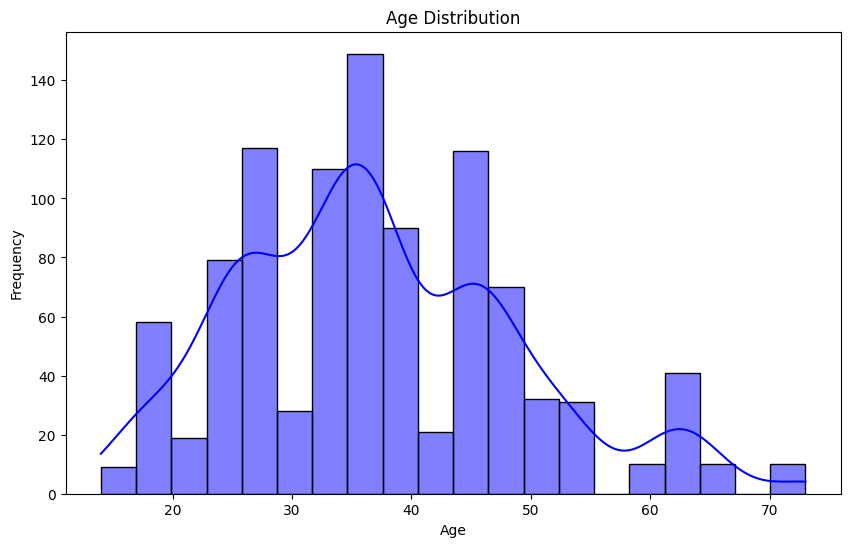

In [109]:
# Age Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], kde=True, bins=20, color='blue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

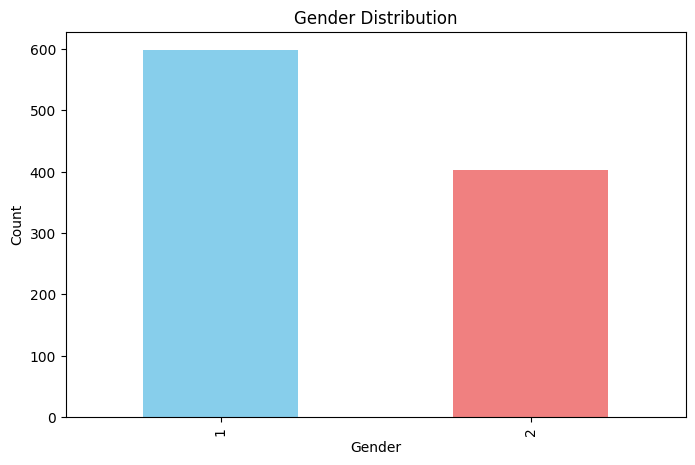

In [110]:
# Gender Distribution
plt.figure(figsize=(8, 5))
gender_counts = df['Gender'].value_counts()
gender_counts.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

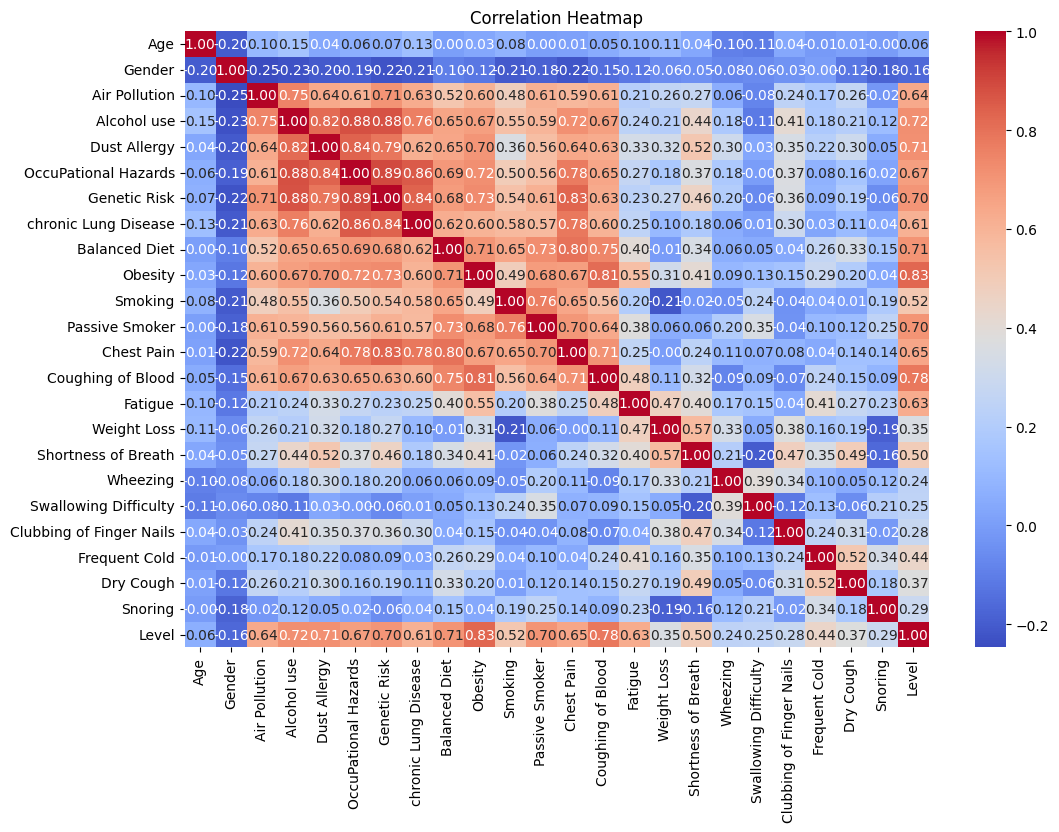

In [111]:
# Correlation Heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

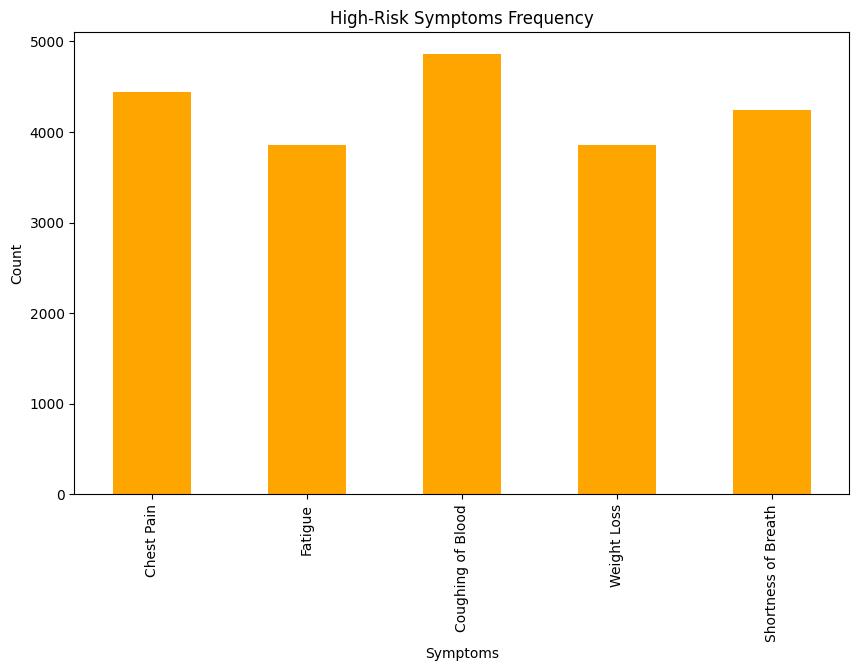

In [112]:
# Bar Plot for High-Risk Symptoms (e.g., Chest Pain, Fatigue, etc.)
high_risk_symptoms = ['Chest Pain', 'Fatigue', 'Coughing of Blood', 'Weight Loss', 'Shortness of Breath']
symptom_counts = df[high_risk_symptoms].sum()

plt.figure(figsize=(10, 6))
symptom_counts.plot(kind='bar', color='orange')
plt.title('High-Risk Symptoms Frequency')
plt.xlabel('Symptoms')
plt.ylabel('Count')
plt.show()

<ipython-input-113-0f85daee3a70>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Level', data=df, palette='viridis')


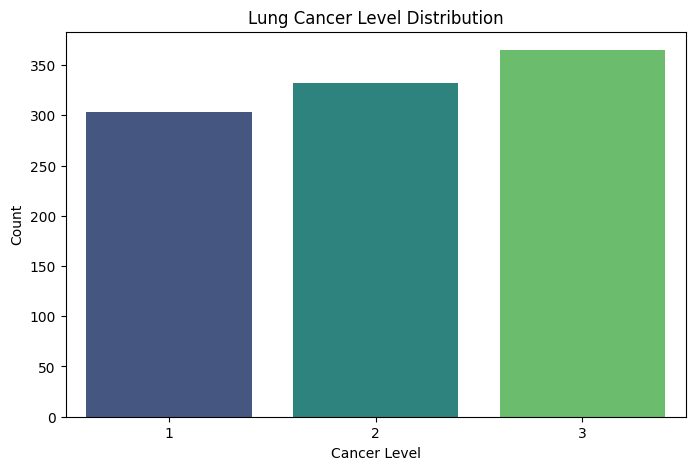

In [113]:
# Level Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Level', data=df, palette='viridis')
plt.title('Lung Cancer Level Distribution')
plt.xlabel('Cancer Level')
plt.ylabel('Count')
plt.show()


# Train, Validate and Test

In [114]:
# Splitting the dataset into 60, 20, 20
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [115]:
def scale_dataset(dataframe, oversample=False):
  X = dataframe[dataframe.columns[:-1]].values
  y = dataframe[dataframe.columns[-1]].values

  scaler = StandardScaler()
  X = scaler.fit_transform(X)

  if oversample:
    ros = RandomOverSampler()
    X, y = ros.fit_resample(X, y)

  data = np.hstack((X, np.reshape(y, (-1, 1))))

  return data, X, y

train, X_train, y_train = scale_dataset(train, oversample=True)
valid, X_valid, y_valid = scale_dataset(valid, oversample=False)
test, X_test, y_test = scale_dataset(test, oversample=False)

In [116]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Continue with model training and evaluation...

In [117]:
# Convert the scaled features back to a DataFrame for better inspection
X_train_scaled_df = pd.DataFrame(X_train_scaled)

# Get the summary statistics of the scaled features
X_train_scaled_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
count,6.330000e+02,6.330000e+02,6.330000e+02,6.330000e+02,6.330000e+02,6.330000e+02,6.330000e+02,6.330000e+02,6.330000e+02,6.330000e+02,...,6.330000e+02,6.330000e+02,6.330000e+02,6.330000e+02,6.330000e+02,6.330000e+02,6.330000e+02,6.330000e+02,6.330000e+02,6.330000e+02
mean,1.122500e-17,5.051252e-17,3.648126e-17,-1.403125e-17,-2.637876e-16,7.436565e-17,-1.010250e-16,-9.821878e-17,-5.837002e-16,1.066375e-16,...,1.347000e-16,1.557469e-16,-2.301126e-16,-1.403125e-17,7.857503e-17,1.515376e-16,-8.418753e-18,1.683751e-17,2.806251e-18,-2.245001e-17
std,1.000791e+00,1.000791e+00,1.000791e+00,1.000791e+00,1.000791e+00,1.000791e+00,1.000791e+00,1.000791e+00,1.000791e+00,1.000791e+00,...,1.000791e+00,1.000791e+00,1.000791e+00,1.000791e+00,1.000791e+00,1.000791e+00,1.000791e+00,1.000791e+00,1.000791e+00,1.000791e+00
min,-1.922917e+00,-8.458411e-01,-1.358979e+00,-1.285224e+00,-2.006675e+00,-1.718167e+00,-1.604507e+00,-1.745042e+00,-1.565355e+00,-1.579199e+00,...,-1.546501e+00,-1.236226e+00,-1.257597e+00,-1.391617e+00,-1.409551e+00,-1.187909e+00,-1.207543e+00,-1.358110e+00,-1.371955e+00,-1.249397e+00
25%,-8.400674e-01,-8.458411e-01,-8.608704e-01,-9.036353e-01,-5.158003e-01,-7.866042e-01,-1.138611e+00,-6.663198e-01,-1.099063e+00,-6.392527e-01,...,-7.200469e-01,-7.791404e-01,-8.063167e-01,-9.487344e-01,-9.065937e-01,-7.567470e-01,-7.790818e-01,-7.969589e-01,-8.728471e-01,-5.580785e-01
50%,-1.736981e-01,-8.458411e-01,-3.627617e-01,-1.404583e-01,-1.884202e-02,1.449589e-01,-2.068195e-01,-1.269586e-01,-1.664801e-01,-1.692794e-01,...,-3.068196e-01,-3.220543e-01,-3.550360e-01,-6.296910e-02,9.932009e-02,1.055768e-01,7.784050e-02,-2.358076e-01,1.253683e-01,1.332399e-01
75%,6.592634e-01,1.182255e+00,1.131565e+00,1.004307e+00,9.750745e-01,1.076522e+00,1.190868e+00,9.517637e-01,1.232395e+00,1.240640e+00,...,9.328622e-01,5.921178e-01,9.988061e-01,8.227962e-01,6.022770e-01,5.367387e-01,5.063017e-01,3.253436e-01,6.244760e-01,8.245582e-01
max,2.991556e+00,1.182255e+00,2.127782e+00,1.385896e+00,1.472033e+00,1.542303e+00,1.190868e+00,1.491125e+00,1.232395e+00,1.240640e+00,...,1.759317e+00,2.420462e+00,1.901368e+00,2.151444e+00,2.111148e+00,1.830224e+00,2.220146e+00,2.008797e+00,1.622691e+00,2.898513e+00


# kNN

In [118]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

knn = KNeighborsClassifier(n_neighbors=5)  # Adjust 'n_neighbors' as needed

knn.fit(X_train, y_train)

y_pred_valid_knn = knn.predict(X_valid)

# Evaluate this model
print("KNN Validation Accuracy:", accuracy_score(y_valid, y_pred_valid_knn))
print("KNN Validation Classification Report:")
print(classification_report(y_valid, y_pred_valid_knn))
print("Confusion matrix: ")
print(confusion_matrix(y_valid, y_pred_valid_knn))

KNN Validation Accuracy: 1.0
KNN Validation Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        54
           2       1.00      1.00      1.00        67
           3       1.00      1.00      1.00        79

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

Confusion matrix: 
[[54  0  0]
 [ 0 67  0]
 [ 0  0 79]]


In [119]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# Assuming X_train and y_train are your features and training target
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

knn = KNeighborsClassifier(n_neighbors=5)
cv_scores = cross_val_score(knn, X_train_scaled, y_train, cv=10, scoring='accuracy')

print("Cross-Validation Accuracy (Training Set):", cv_scores.mean())

# Using validation set explicitly for final evaluation after tuning
X_valid_scaled = scaler.transform(X_valid)
knn.fit(X_train_scaled, y_train)
validation_accuracy = knn.score(X_valid_scaled, y_valid)
print("Validation Set Accuracy:", validation_accuracy)


Cross-Validation Accuracy (Training Set): 0.9952628968253968
Validation Set Accuracy: 1.0


# Random Forest Classifier

In [120]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest
rf = RandomForestClassifier(random_state=42)

# Fit the model
rf.fit(X_train, y_train)

# Validate
y_pred_valid_rf = rf.predict(X_valid)

# Evaluate
print("Random Forest Validation Accuracy:", accuracy_score(y_valid, y_pred_valid_rf))
print("Random Forest Validation Classification Report:")
print(classification_report(y_valid, y_pred_valid_rf))

Random Forest Validation Accuracy: 1.0
Random Forest Validation Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        54
           2       1.00      1.00      1.00        67
           3       1.00      1.00      1.00        79

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [121]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)

print("Best Parameters for Random Forest:", grid_search_rf.best_params_)

Best Parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}


## A Quick Comparison between the two models


Final Model Comparison:
KNN Final Accuracy: 1.0
Random Forest Final Accuracy: 1.0


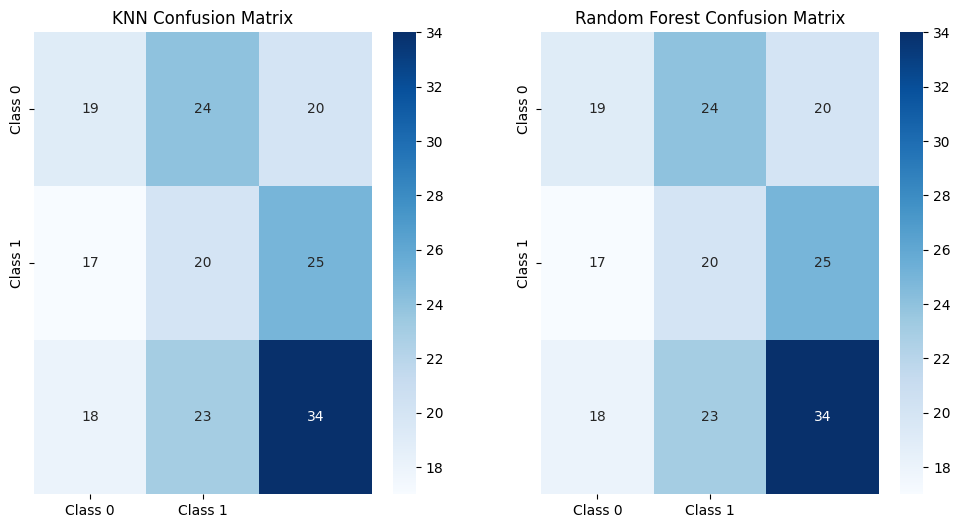

In [122]:
print("\nFinal Model Comparison:")
print("KNN Final Accuracy:", accuracy_score(y_valid, y_pred_valid_knn))
print("Random Forest Final Accuracy:", accuracy_score(y_valid, y_pred_valid_rf))

# Optional: Confusion Matrix and Cross-Validation
conf_matrix_knn = confusion_matrix(y_test, y_pred_valid_knn)
conf_matrix_rf = confusion_matrix(y_test, y_pred_valid_rf)

# Plot confusion matrices
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('KNN Confusion Matrix')

plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Random Forest Confusion Matrix')
plt.show()